# Running deep learning models with BioEngine

This tutorial covers 3 models:
 * UNet for Neuron segmentation (Falk et al. Nature Methods 2019)
 * Stardist (Weigert et. al 2020
 * Inception model for single cell protein localization classification (by Bestfitting in the HPA single cell classification competition 2021)

 
Note: Please be aware that the data will be sent to a remote server (https://ai.imjoy.io/triton) running by the ImJoy team, the service is for evaluation purpose only and it is subject to change without notice. In the near future we will release the deployment toolkit so you can also run your own server easily.

In [1]:
try:
    # For pyodide in the browser
    import micropip
    await micropip.install(['imjoy-rpc', 'kaibu-utils', 'pyodide-http', 'requests'])
    
    # 2. Patch requests
    import pyodide_http
    pyodide_http.patch_all()  # Patch all libraries
except ImportError:
    # For native python with pip
    import subprocess
    subprocess.call(['pip', 'install', 'imjoy-rpc', 'kaibu-utils'])

import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
#from pyotritonclient import execute
from imjoy_rpc.hypha import connect_to_server
from kaibu_utils import fetch_image




In [2]:
# Server URL: For this workshop we will use the ai.imjoy.io server
SERVER_URL = "https://ai.imjoy.io"

# Running UNet membrane segmentation model via the BioEngine

## Download an example image

example image downloaded:  (512, 512)


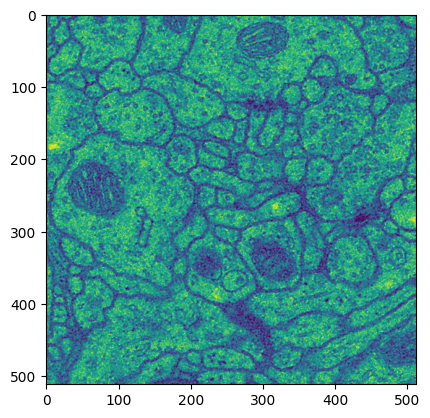

In [3]:
image = await fetch_image('https://zenodo.org/api/records/5906839/files/sample_input_0.tif/content')
image = image.astype('float32')
print("example image downloaded: ", image.shape)
plt.imshow(image)
plt.show()

## Connect to the server

In [4]:
server = await connect_to_server(
        {"server_url": SERVER_URL, "method_timeout": 3000}
    )
triton = await server.get_service("triton-client")

## Make prediction with the BioEngine

In [5]:
ret = await triton.execute(inputs=[{"inputs":[[image[...,None]]], "model_id": "creative-panda"}],
                           model_name="bioengine-model-runner",
                           serialization="imjoy",
                          )
result = ret["result"]
mask = result['outputs'][0]
print('prediction: ', mask.shape)

prediction:  (1, 512, 512, 1)


## Display the segmentation result

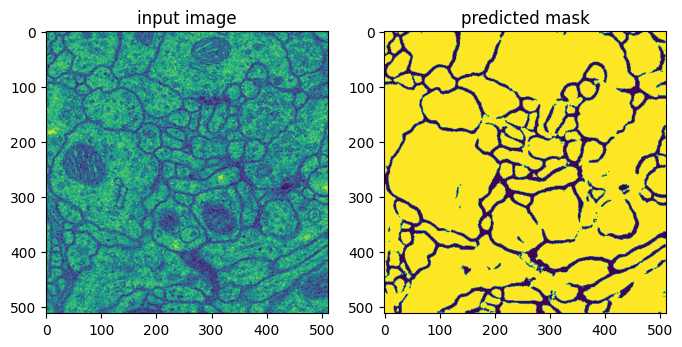

In [6]:
# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(image.astype('uint8'))
ax1.set_title('input image')
ax2.imshow(mask[0])
ax2.set_title('predicted mask')
plt.show()

# Running Stardist nuclei segmentation via the BioEngine

In [ ]:
# obtain the model config
image = await fetch_image('https://raw.githubusercontent.com/stardist/stardist/3451a4f9e7b6dcef91b09635cc8fa78939fb0d29/stardist/data/images/img2d.tif', grayscale=True)
image = image.astype('uint16')
param = {'diameter': 30}

# run inference
ret = await triton.execute(inputs=[{
                               "inputs":[[image[...,None]]], 
                               "model_id": "fearless-crab"}], 
                           model_name="bioengine-model-runner",
                           serialization="imjoy",
                          )
result = ret["result"]
mask = result['outputs'][0]
print('prediction: ', mask.shape)
print('Note: use the stardist library to properly post-process this output! https://github.com/stardist/stardist')

# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(image)
ax1.set_title('input image')
ax2.imshow(mask[0, :, :, 0])
ax2.set_title('predicted mask')
plt.show()

### Exercise

Try running this notebook locally, and see if you can run `stardist` to properly post-process the results from above. 

# Running HPA single-cell classification model via the BioEngine


## Preparation

In [ ]:
LABELS = {
  0: 'Nucleoplasm',
  1: 'Nuclear membrane',
  2: 'Nucleoli',
  3: 'Nucleoli fibrillar center',
  4: 'Nuclear speckles',
  5: 'Nuclear bodies',
  6: 'Endoplasmic reticulum',
  7: 'Golgi apparatus',
  8: 'Intermediate filaments',
  9: 'Actin filaments',
  10: 'Microtubules',
  11: 'Mitotic spindle',
  12: 'Centrosome',
  13: 'Plasma membrane',
  14: 'Mitochondria',
  15: 'Aggresome',
  16: 'Cytosol',
  17: 'Vesicles and punctate cytosolic patterns',
  18: 'Negative',
}

COLORS =  ["red", "green", "blue", "yellow"]

async def fetch_hpa_image(image_id, size=None):
    crops = []
    for color in COLORS:
        image = await fetch_image(f'https://images.proteinatlas.org/{image_id}_{color}.jpg', grayscale=True, size=size)
        crops.append(image)
    image = np.stack(crops, axis=0)
    # assert image.shape == (4, 128, 128)
    return image

## Fetch an image from HPA website by its ID

In [ ]:
image_raw = await fetch_hpa_image('115/672_E2_1', size=(340, 340))

# crop the image to a single cell
image_raw = image_raw[:, 60:188, 120:248]
    

# display the image
plt.imshow(image_raw.transpose(1,2,0)[:,:,:3])
plt.show()

## Making prediction with the BioEngine

In [ ]:

ret = await triton.execute(inputs=[image.astype('float32')/255],
                        #server_url='https://ai.imjoy.io/triton',
                        model_name='bestfitting-inceptionv3-single-cell')
classes = ret['classes']
pred = [(LABELS[i], prob) for i, prob in enumerate(classes.tolist()) if prob>0.5]

print(f'Prediction: {pred}')
